In [91]:
# importing standard packages
import pandas as pd
import numpy as np 
from scipy import stats 

# importing the plot funnctions
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

# preprocessing/ model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# importing the classifiers 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# importing the metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,f1_score
from sklearn.metrics import roc_curve

# oversampling techniques 
from imblearn.over_sampling import SMOTE

# importing model saving package 
from joblib import dump, load


## Functions for Notebooks

In [92]:
def draw_conf_mat(mat):
    
    """
    Draw confusion matrix
    
    Parameters:
    ------------------
    mat:                ndarray of shape (n_classes, n_classes) 
                        confusion matrix

    """
    
    import matplotlib.pyplot as plt 
    import seaborn as sns
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(mat, annot=True, fmt="d",
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
    return ax

In [93]:
def draw_roc_curve(y_true, y_proba):
    
    """
    Draw baseline and model roc curve
    
    Parameters:
    ------------------
    y_true:             array-like of shape (n_samples,) 
                        True label of target (y)
                        
    y_proba             array-like of shape (n_samples,)
                        The predicted probability of target (y)
    """
    
    
    base_fpr, base_tpr, _ = roc_curve(y_true, [1 for _ in range(len(y_true))])
    model_fpr, model_tpr, _ = roc_curve(y_true, y_proba)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    
    return ax

In [94]:
def metrics_imbalanced(your_confusion_matrix, y_true, y_proba):
    
    """
    Print precision, recall, fallout and auroc score based on the confusion matrix. 
    
    Parameters:
    ------------------
    your_confusion_matrix:                ndarray of shape (n_classes, n_classes) 
                                          confusion matrix
                                          
    y_true:                               array-like of shape (n_samples,) 
                                          True label of target (y)
                                          
    y_proba:                              y_proba             array-like of shape (n_samples,)
                                          The predicted probability of target (y)
    """
    
    # Model evaluation metrics. 
    tp = your_confusion_matrix[1,1]
    fn = your_confusion_matrix[1,0]
    fp = your_confusion_matrix[0,1]
    tn = your_confusion_matrix[0,0]
    auroc = roc_auc_score(y_true, y_proba)
    
    print('Precision = %0.3f'%(tp/(tp+fp)))
    print('Recall (TPR) = %0.3f'%(tp/(tp+fn)))
    print('Fallout (FPR) = %0.3f'%(fp/(fp+tn)))
    print('Roc_auc_score = %0.3f'%auroc)

In [95]:
def resampling_unbalanced(train_x, train_y, sample_method):
    """ 

    Parameters
    ----------
    train_x : test_x 
            pd.DataFrame
    train_y : train_y 
            pd.DataFrame
    sample_method: 'over' or 'under'
            string

    Returns
    -------
    train_x : resampled train_x
                pd.DataFrame
    train_y : resampled train_y
                pd.DataFrame
        

    """
    
    
    if sample_method == "over":
        oversample = SMOTE()
        train_x_ros, train_y_ros = oversample.fit_resample(X_train, y_train)
        
        return train_x_ros, train_y_ros
        
    if sample_method == "under":
        # Concate X and Y train
        trainData = pd.concat([train_x, train_y],axis=1)
        # Class count
        count_class_0, count_class_1 = trainData["hospital_death"].value_counts()

        # Divide by class
        df_class_0 = trainData[trainData['hospital_death'] == 0]
        df_class_1 = trainData[trainData['hospital_death'] == 1]
        
        # Sample the majority class
        df_class_0_under = df_class_0.sample(count_class_1)
        
        # Put the train dataset together
        train_rus = pd.concat([df_class_0_under, df_class_1], axis=0)
        train_x_rus = train_rus.drop("hospital_death", axis = 1)
        train_y_rus = pd.DataFrame(train_rus['hospital_death'])
        
        return train_x_rus, train_y_rus

## Bring in the X_wids and y_wids from the WIDS_Feature_Engineer.ipynb
Run the WIDS Feature Engineer Notebook first in order to grab the dataframes

In [96]:
# grab the stored data frames
%store -r X_wids
%store -r y_wids

In [97]:
X_wids.shape, y_wids.shape

((91713, 453), (91713, 1))

## Train Test Split without Correction of Imbalanced Data

In [98]:
# Split train-test dataset 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_wids, y_wids, test_size = 0.2, random_state = 31, stratify = y_wids)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(73370, 453) (18343, 453) (73370, 1) (18343, 1)


## Models with No Correction Of Imbalanced Data

In [0]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'XG': XGBClassifier(n_jobs = 1, learning_rate = .1, n_estimators = 100, objective = 'binary', booster='gbtree', max_depth = 7 ),
              'RF': RandomForestClassifier(n_estimators= 100, max_depth = 7),
              'LGB': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [0]:
# keys of the classifiers 
selected_clfs = ['XG', 'RF', 'LGB']

In [0]:
# create the clf_matrix 
clf_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):

    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train,y_train)
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train
    y_train_predict = clf.predict(X_train)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test, y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test, y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test, y_proba)

    #f1 score on test
    f1_test = f1_score(y_test, y_predict)

    #f1 score on train
    f1_train = f1_score(y_train, y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train, y_train, cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_matrix = pd.concat([df2, clf_matrix])


In [0]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)


## Models with Correction Of Imbalanced Data Using Undersampling

In [0]:
# # create a dictionary of classifers with the hyperparameters you would like to try 
# classifiers = {'XG_U': XGBClassifier(n_jobs = 1, learning_rate = .1, n_estimators = 100, objective = 'binary', booster='gbtree', max_depth = 7 ),
#               'RF_U': RandomForestClassifier(n_estimators= 100, max_depth = 7),
#               'LGB_U': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [0]:
# # keys for the classifiers 
# selected_clfs = ['XG_U', 'RF_U', 'LGB_U']

In [99]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'LGB_U': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [100]:
# keys for the classifiers 
selected_clfs = ['LGB_U']

new train test split for imbalanced data. Undersampling Data!

In [101]:
X_train_U, y_train_U = resampling_unbalanced(X_train, y_train, "under")

In [102]:
X_train_U.shape, y_train_U.shape

((12664, 453), (12664, 1))

In [103]:
clf_under_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):

    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train_U, y_train_U)
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train
    y_train_predict = clf.predict(X_train_U)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test, y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test, y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test, y_proba)

    #f1 score on test
    f1_test = f1_score(y_test, y_predict)

    #f1 score on train
    f1_train = f1_score(y_train_U, y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train_U, y_train_U, cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_under_matrix = pd.concat([df2, clf_under_matrix])


/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------- classifier being run is LGB_U ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------


/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------


LGB_U


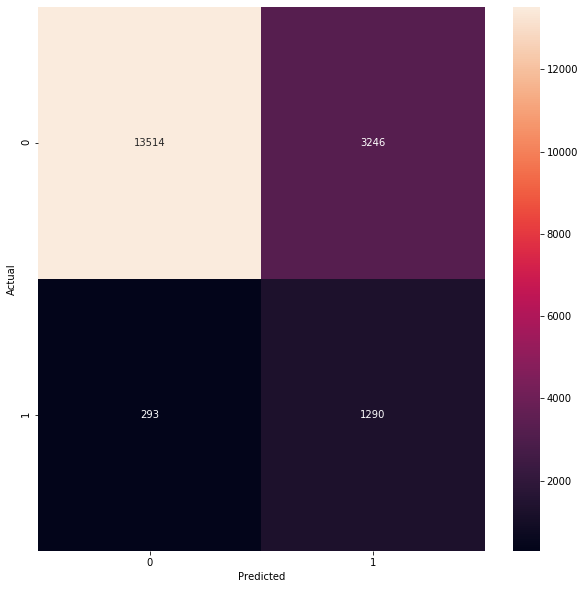

In [104]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)

In [105]:
clf_under_matrix

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB_U,0.284392,0.814908,0.193675,0.896877,0.421638,0.912283,"[0.7998719180275375, 0.8095387511766552, 0.806..."


## Models with Correction Of Imbalanced Data Using Oversampling SMOTE 

In [0]:
# # create a dictionary of classifers with the hyperparameters you would like to try 
# classifiers = {'XG_O': XGBClassifier(n_jobs = 1, learning_rate = .1, n_estimators = 100, objective = 'binary', booster='gbtree', max_depth = 7 ),
#               'RF_O': RandomForestClassifier(n_estimators= 100, max_depth = 7),
#               'LGB_O': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [0]:
# select_clfs = ['XG_O', 'RF_O', 'LGB_O']

In [106]:
# create a dictionary of classifers with the hyperparameters you would like to try 
classifiers = {'LGB_O': LGBMClassifier(booster ='gbtree', n_estimators = 100, learning_rate = .1, max_depth = 7, objective ='binary')}

In [107]:
selected_clfs = ['LGB_O']

In [108]:
X_train_O, y_train_O = resampling_unbalanced(X_train, y_train, "over")

In [109]:
X_train_O.shape, y_train_O.shape

((134076, 453), (134076, 1))

In [110]:
clf_over_matrix = pd.DataFrame(columns = ['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])

# for every classifer in the selected classifers list
for idx, classifier in enumerate(selected_clfs):
    print(classifier)
    # get the classifer and hyperparameters from the model
    clf = classifiers[classifier]

    # fit the model 
    clf.fit(X_train_O,y_train_O)
    print(f"-------- classifier being run is {classifier} ---------")

    print(f"-------- saving the the model ---------")
    # Write the model to file
    dump(clf, '{}.joblib'.format(classifier)) 

    print(f"-------- computing y_predict, y_prob, y_train_predict ---------")
    # prediction of y based on X_test
    y_predict = clf.predict(X_test)
    # prediction of y probability based on X_test
    y_proba = clf.predict_proba(X_test)[:,1]
    # prediction of y based on X_train_O
    y_train_predict = clf.predict(X_train_O)

    print(f"-------- creating the confusion matrix ---------") 
    # confusion matrix 
    cmat = confusion_matrix(y_test, y_predict)
    # tp, fn, fp, tn
    tp = cmat[1,1]
    fn = cmat[1,0]
    fp = cmat[0,1]
    tn = cmat[0,0]

    print(f"-------- calculating the metrics ---------") 
    #precision score on test
    p_score_test = precision_score(y_test, y_predict)

    #recall score on test
    r_score_test = tp/(tp+fn) 

    #FPR score on test
    fpr_test = fp/(fp+tn)

    #AUROC score on test
    auroc_test = roc_auc_score(y_test, y_proba)

    #f1 score on test
    f1_test = f1_score(y_test, y_predict)

    #f1 score on train
    f1_train = f1_score(y_train_O, y_train_predict)

    #f1 score on cross validation 
    k_fold = 4
    f1_cv = cross_val_score(clf, X_train_O, y_train_O, cv=k_fold, scoring = 'f1')
    print(f"Cross Validation is on {k_fold} folds.")

    print(f"-------- append values to the model matrix  ---------") 

    # append to matrix
    df2 = pd.DataFrame([[classifier,p_score_test,r_score_test, fpr_test, auroc_test, f1_test, f1_train, f1_cv]], columns=['model', 'precision_test', 'recall_test', 'FPR_test', 'AUROC_test',
                                     'f1_test', 'f1_train', 'f1_CV'])
    
    clf_over_matrix = pd.concat([df2, clf_over_matrix])


LGB_O


/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------- classifier being run is LGB_O ---------
-------- saving the the model ---------
-------- computing y_predict, y_prob, y_train_O_predict ---------
-------- creating the confusion matrix ---------
-------- calculating the metrics ---------


/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vivianahernandez/anaconda3/envs/uchi/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross Validation is on 4 folds.
-------- append values to the model matrix  ---------


LGB_O


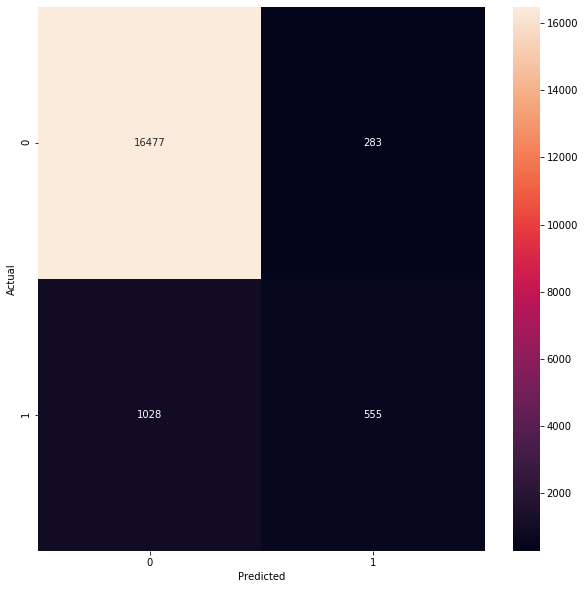

In [111]:
# Draw confusion matrix for each model 
for classifier in selected_clfs:

  # Load model saved
  clf = load('{}.joblib'.format(classifier)) 

  # Predict y based on X_test
  y_predict = clf.predict(X_test)

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)

  # Draw
  print(classifier)
  draw_conf_mat(cm)

In [116]:
clf_over_matrix.explode('f1_CV')

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB_O,0.662291,0.3506,0.016885,0.894673,0.458488,0.96558,0.770224
0,LGB_O,0.662291,0.3506,0.016885,0.894673,0.458488,0.96558,0.988901
0,LGB_O,0.662291,0.3506,0.016885,0.894673,0.458488,0.96558,0.988283
0,LGB_O,0.662291,0.3506,0.016885,0.894673,0.458488,0.96558,0.987935


In [117]:
clf_under_matrix.explode('f1_CV')

,model,precision_test,recall_test,FPR_test,AUROC_test,f1_test,f1_train,f1_CV
0,LGB_U,0.284392,0.814908,0.193675,0.896877,0.421638,0.912283,0.799872
0,LGB_U,0.284392,0.814908,0.193675,0.896877,0.421638,0.912283,0.809539
0,LGB_U,0.284392,0.814908,0.193675,0.896877,0.421638,0.912283,0.806221
0,LGB_U,0.284392,0.814908,0.193675,0.896877,0.421638,0.912283,0.810725
